# The Capstone Project of MLND - Face Recognition for My Family Members

## I. Definition
### Project Overview
The iCloud photos from iOS or Mac OS provided a comprenesive way to tag faces. All the photos in the library will be scanned, thereafter faces will be identified and tagged accordingly based on the earlier defined tags/names.

I am a photography enthusiast and I have started to taking photos from year 2004. As of today, it's over 200k shots and I've kept 40k of them. There are many desktop applications can do the job of face recognition, but it's going to be super fun if I can build the solution end to end.

Many other interesting use cases can be further built/extended by this, for example, auto greeting to the person sitting in front of the computer by calling his/her name. However, this won't be covered in this project.

### Problem Statement
There are many great online blogs/projects discussed about the detailed mathematics and implementation of face recognition. For exmaple, [this one](https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78). I don't have plan to approach my problem in that way which may be too difficult and time consuming for me.

The first two questions came to my mind about this project were how to minimize the distraction factors and how to extract features understood by computers. All my photos are about something or somebody and I bet none of them is about a single face only. This project is about face recognition and all the other factors other than faces will be 'noice' and should be avoided before any machine learning kicking in. A 300 \* 300 pixcel color photo is quite good for human eye to distinguish faces. But it's a vector of size 300 \* 300 \* 3 = 270,000 which sounds too big to be machine learnt by today's computer. After some research and experiments I decided to use OpenCV to detect/extract faces and then Google Inception V3 to extract features from the face photos.

### Metrics
Without any doubt, accuracy is the most important metric for any machine learning problem and it still holds true for this project. A model is useless if it performs only slightly better than a random guess. Speed is another important metric especially when we deal with large scale of data. I don't have the intention to scale the model to that level but I will evaluate the performance based on speed as well.

### Workflow of the Approach


1. Preprocess and manual labeling.
    1. Scan all photos, detect faces and save them as new images with dimension of 299 * 299 pixels.
    2. Handle pick eligible photos and save them into respective folders. There will be seven folders named `me`, `wife`, `daughter`, `son`, `dad`, `mum`, `brother`.
2. Apply Google Inception V3 model to extract the feature vectors of each face image.
3. Apply different models.
    1. Apply linear classifier.
    2. Apply KNN.
    3. Apply PCA with KNN.
    4. Deep learning model.
4. Performance metrics and benchmark. Linear classifier as the baseline.
5. Conclusion.

## II. Analysis
### Data Exploration
All my photos are in `D:\Pictures`, majority of them are in both `.jpg` and `.nef` format. The `.nef` is a raw image format for Nikon cameras and `.jpg` is the copy after image post-processing of raw file.

The output of below code chunk shows the root directory of my photo library. For each photo its full address always follows `D:\Pictures\[yyyy]\[yyyy.mm.dd] - [event name]\[yyyymmdd-hhmm][-index].jpg`

In [1]:
import os
from time import time
cur_dir = os.getcwd()
#print(cur_dir)
target_image_dir = os.path.join(cur_dir, 'images')
photo_dir = 'D:\Pictures'
os.listdir(photo_dir)

['.SynologyWorkingDirectory',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 'Adobe Lightroom',
 'Camera Roll',
 'desktop.ini',
 'iCloud Photos',
 'Phone Photos',
 'Photography Works',
 'Readme.txt',
 'Saved Pictures',
 'SyncToy_6288703e-b478-4b80-9f48-ece12cdcb521.dat',
 'zbingjie',
 'zothers',
 '法蝶',
 '熊思宇和黄乐论辩论']

A glance of a recent photo directory. Each and every file use the time stamp as its file name. `.nef` is the raw image file, `.xmp` is generated by Adobe Lightroom, both are not applicable to this project. Only `.jpg` files are applicable to this project.

In [2]:
os.listdir(os.path.join(photo_dir, '2018'))

['2018.01.01 - 冰洁爸妈证件照', '2018.01.01 - 彤彤和祺祺']

In [3]:
os.listdir(os.path.join(photo_dir, '2018', '2018.01.01 - 彤彤和祺祺'))

['20180101-0933-2.JPG',
 '20180101-0933-2.NEF',
 '20180101-0933-2.xmp',
 '20180101-0933.JPG',
 '20180101-0933.NEF',
 '20180101-0933.xmp',
 '20180101-1039.jpg',
 '20180101-1039.NEF',
 '20180101-1039.xmp',
 '20180101-1042-2.jpg',
 '20180101-1042-2.NEF',
 '20180101-1042-2.xmp',
 '20180101-1042.jpg',
 '20180101-1042.NEF',
 '20180101-1042.xmp',
 '20180101-1043-10.jpg',
 '20180101-1043-10.NEF',
 '20180101-1043-10.xmp',
 '20180101-1043-11.jpg',
 '20180101-1043-11.NEF',
 '20180101-1043-11.xmp',
 '20180101-1043-12.jpg',
 '20180101-1043-12.NEF',
 '20180101-1043-12.xmp',
 '20180101-1043-7.jpg',
 '20180101-1043-7.NEF',
 '20180101-1043-7.xmp',
 '20180101-1043-8.jpg',
 '20180101-1043-8.NEF',
 '20180101-1043-8.xmp',
 '20180101-1043-9.jpg',
 '20180101-1043-9.NEF',
 '20180101-1043-9.xmp',
 '20180101-1043.jpg',
 '20180101-1043.NEF',
 '20180101-1043.xmp',
 '20180101-1044-2.jpg',
 '20180101-1044-2.NEF',
 '20180101-1044-2.xmp',
 '20180101-1044.jpg',
 '20180101-1044.NEF',
 '20180101-1044.xmp',
 '20180101-10

All the photo files are in folders whose names are in year format. There are slightly more than 40k photos, 5 of them were randomly picked to show the full address.

In [4]:
def get_all_file_path(folder_addr):
    """Return all jpg files' full path as a list
    Args:
        folder_add (str): The folder address.
    Returns:
        all_jpg (list): A list of strings which are the full path of jpg files.
    """
    all_jpg = []
    for root, dirs, files in os.walk(folder_addr):
        # All the target photos are in D:\Pictures\20xx. Get the jpgs from them only.
        path = root.split(os.sep)
        if len(path) < 3:
            continue
        else:
            year = path[2]
            if year[:2] != '20':
                continue
        #print((len(path) - 1) * '---', os.path.basename(root))
        for file in files:
            if file[-3:].lower() == 'jpg':
                #print(len(path) * '---', file)
                all_jpg.append(os.path.join(root, file))
    return all_jpg
            
all_jpg = get_all_file_path(photo_dir)

In [5]:
import random
print('Number of jpgs:', len(all_jpg))
for i in random.sample(range(len(all_jpg)), 5):
    print(all_jpg[i])

Number of jpgs: 40231
D:\Pictures\2008\2008.08.29~2008.09.06 - 可爱的蚂蚁\20080829-1853.JPG
D:\Pictures\2005\2005.09.11 - 8th SM2 camp晚会\20050911-2057-10.JPG
D:\Pictures\2008\2008.08.31 - Republic of Singapore air force\20080831-1203.JPG
D:\Pictures\2008\2008.06.05~06 - 北京行（天安门、国子监、后海）\20080605-1503-2.JPG
D:\Pictures\2010\2010.07.11 - OCBC TC1\20100712-1125-1.jpg


### Sample Photo Visualization and Pre-processing
This section illustrates the workflow to preprocess one image before extracting face features.

In [6]:
# Import required libraries for this section
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import time
DISPLAY = True
SAVE = True
NODISPLAY = False
NOSAVE = False

In [7]:
def get_numpy_from_file(file_path):
    """Return the image file as a numpy array
    Args:
        file_path (str): The full address of the image file.
    Returns:
        image (numpy.ndarray): The numpy array of the image file. Shape of (width, height, number of channels).
        
    The file_path may contain unicode characters, cannot use cv2.imread() directly. Below way works for both 
    unicode and non-unicode paths.
    """
    file_stream = open(file_path, 'rb')
    bytes_arr = bytearray(file_stream.read())
    numpy_ar = np.asarray(bytes_arr, dtype=np.uint8)
    image = cv2.imdecode(numpy_ar, cv2.IMREAD_UNCHANGED)
    print('Image numpy array shape:', image.shape, type(image))
    return image

def display_from_numpy(image, fig_dim_x=10, fig_dim_y=10, plot_nrows=1, plot_ncols=1):
    """Display the image from a given numpy array (the returned result from get_numpy_from_file() function).
    Args:
        image (numpy.ndarray): The numpy array representation of an image.
        image (list[numpy.ndarr]): The list of numpy arrays of images.
    Returns:
        inline display of the image.
    """
    fig = plt.figure(figsize=(fig_dim_x, fig_dim_y))
    if isinstance(image, list):
        image_list = image
    else:
        image_list = []
        image_list.append(image)
    for i in range(len(image_list)):
        ax = fig.add_subplot(plot_nrows, plot_ncols, i+1, xticks=[], yticks=[])
        ax.set_title('Sample Image')
        ax.imshow(image_list[i])

def display_from_file(file_path):
    """Display one image file inline.
    Args:
        file_path (str): The full address of the file
    Returns:
        None: Display image inline.
    """
    image = get_numpy_from_file(file_path)
    # Need to convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    display_from_numpy(image)

Image numpy array shape: (4760, 7132, 3) <class 'numpy.ndarray'>


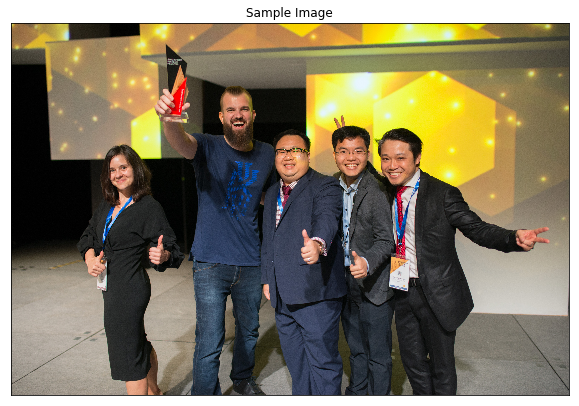

In [8]:
file_path = os.path.join(photo_dir, '2017', '2017.11.16 - Singapore Fintech Festival', '20171116-1923.jpg')
display_from_file(file_path)

The above is a group photo with 5 people. As mentioned earlier, this project focuses on face only. So the next step will be extracting the 5 faces and save them as 5 different image files with 299 \* 299 pixels.

There are many supporting functions and process_faces() is the entry one with many flags to represent whether need to display or save the given image file.

In [15]:
# pathlib available from python 3.5
from pathlib import Path
def get_faces(image, scaleFactor, minNeighb):
    """Perform face detection and return the detected faces as a list of (x,y,w,h).
    Args:
        image (numpy.ndarray): The numpay array of an image.
        scaleFactor (float): The scaling factor to be used by the detectMultiScale() function.
        minNeighb (int): The number of minimum neighbors to be used by the detectMultiScale() function.
    Returns:
        faces (list of tuples): The list of the face locations.
    """
    # Convert to RGB then to grayscale
    image = np.copy(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Extract the pre-trained face detector from an xml file
    face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
    # Detect the faces in image
    faces = face_cascade.detectMultiScale(gray, scaleFactor, minNeighb)
    return faces
        
def draw_bounding_box(image, faces):
    """Draw the bounding box of faces on the image.
    Args:
        image (np.ndarray): Numpy array of the image.
        faces (list of tuples): The list of the face locations.
    Return:
        image_with_detections (np.ndarray): A image with bounding box on faces, in numpy array format,
            after converting to RGB.
        image_faces (list[np.ndarray]): List of face images.
    """
    # Use np.copy() to create duplicate images to avoid aleration of the original image.
    image_copy = np.copy(image)
    image_with_detections = np.copy(image)
    image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
    image_with_detections = cv2.cvtColor(image_with_detections, cv2.COLOR_BGR2RGB)
    # The list of detected faces
    image_faces = []
    # Get the bounding box for each detected face
    for (x,y,w,h) in faces:
        # Add a red bounding box to the detections image
        if w > 200:
            line_width = w//20
        else:
            line_width = 3
        image_faces.append(image_copy[y:(y+h), x:(x+w)])
        cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), line_width)
    return image_with_detections, image_faces

def create_get_target_dir_file(file_path):
    """Create the target directory if it's not existent, return the target directory as string
    Args:
        None: Global variables.
    Returns:
        target_dir (str): The address of the target directory.
    """
    # Create the full path of the target images by replacing the photo_dir string into target_image_dir string.
    target_file = file_path.replace(photo_dir, target_image_dir)
    target_dir = os.path.dirname(target_file)
    target_path = Path(target_dir)
    
    # Create parents of directory, don't raise exception if the directory exists
    target_path.mkdir(parents=True, exist_ok=True)
    return target_dir, target_file

def save_faces(file_path, image_faces):
    """Save each face image into new files in target_iamge_dir.
    Args:
        file_path (str): The full path of the original photo.
        image_faces (list[np.ndarray]): The list of face images, in numpy array format.
    Returns:
        None
    """
    if len(image_faces) == 0:
        return
    
    target_dir, target_file = create_get_target_dir_file(file_path)
    
    # Resize and save each face image.
    for i, face in enumerate(image_faces):
        face = cv2.resize(face, (299, 299))
        os.chdir(target_dir)
        file_name = os.path.basename(target_file)
        cv2.imwrite(file_name + '-face-' + str(i) + '.jpg', cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        print(os.path.join(target_dir, file_name + '-face-' + str(i) + '.jpg'), 'saved.')
        
def process_faces(file_path, display=NODISPLAY, save=NOSAVE, scaleFactor=1.3, minNeighb=5):
    """Process the input image file by extracting face(s). Display and save based on the flags.
    Args:
        file_path (str): The full path of the input image file.
        display (bool): Default is NODISPLAY/False.
        save (bool): Default is NOSAVE/False.
        scaleFactor (float): The scaling factor used by face detection function.
        minNeighb (int): The number of minimum neighbors.
    Returns:
        None: Perform display or save actions based on the flags.
    """
    print('Image path', file_path)
    image = get_numpy_from_file(file_path)
    faces = get_faces(image, scaleFactor, minNeighb)
    print('Number of faces detected:', len(faces))

    image_with_detections, image_faces = draw_bounding_box(image, faces)
    
    if save:
        save_faces(file_path, image_faces)

    if display:
        # Display the image with the detections
        display_from_numpy(image_with_detections)
        
    # Return to this project's current working directory
    os.chdir(cur_dir)

Image path D:\Pictures\2017\2017.11.16 - Singapore Fintech Festival\20171116-1923.jpg
Image numpy array shape: (4760, 7132, 3) <class 'numpy.ndarray'>
Number of faces detected: 5
D:\Google Drive\Study\Machine Learning Engineer Nanodegree - Udacity\Projects\MLND-Projects\projects\facial_recognition_family_members\images\2017\2017.11.16 - Singapore Fintech Festival\20171116-1923.jpg-face-0.jpg saved.
D:\Google Drive\Study\Machine Learning Engineer Nanodegree - Udacity\Projects\MLND-Projects\projects\facial_recognition_family_members\images\2017\2017.11.16 - Singapore Fintech Festival\20171116-1923.jpg-face-1.jpg saved.
D:\Google Drive\Study\Machine Learning Engineer Nanodegree - Udacity\Projects\MLND-Projects\projects\facial_recognition_family_members\images\2017\2017.11.16 - Singapore Fintech Festival\20171116-1923.jpg-face-2.jpg saved.
D:\Google Drive\Study\Machine Learning Engineer Nanodegree - Udacity\Projects\MLND-Projects\projects\facial_recognition_family_members\images\2017\2017.

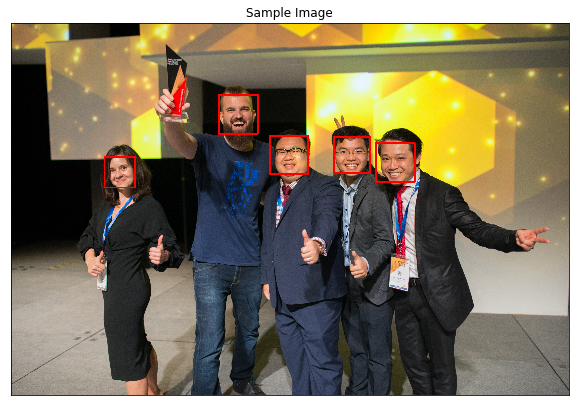

In [13]:
# Load in color image for face detection
file_path = os.path.join(photo_dir, '2017\\2017.11.16 - Singapore Fintech Festival', '20171116-1923.jpg')
process_faces(file_path, DISPLAY, SAVE)

In [9]:
def get_file_path_from_folder(folder_addr):
    """Return all jpg files' full path as a list
    Args:
        folder_add (str): The folder address.
    Returns:
        all_jpg (list): A list of strings which are the full path of jpg files.
    """
    all_jpg = []
    for root, dirs, files in os.walk(folder_addr):
        for file in files:
            if file[-3:].lower() == 'jpg':
                #print(len(path) * '---', file)
                all_jpg.append(os.path.join(root, file))
    return all_jpg

def get_numpy_from_folder(folder_addr):
    """Return all jpg files in a folder as numpy arrays.
    Args:
        folder_addr (str): The folder address.
    Returns:
        image_numpys (list[numpy.ndarrays]): The list of numpy arrays of jpg images in a folder.
    """
    all_jpg_addr = get_file_path_from_folder(folder_addr)
    image_numpys = []
    for jpg_addr in all_jpg_addr:
        image = get_numpy_from_file(jpg_addr)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_numpys.append(image)
    return image_numpys

In [10]:
image_numpys = get_numpy_from_folder(os.path.join(cur_dir, 'images\\2017\\2017.11.16 - Singapore Fintech Festival'))
display_from_numpy(image_numpys, fig_dim_x=15, fig_dim_y=5, plot_nrows=1, plot_ncols=5)

### Batch Pre-process All Images.

In the earlier section, all the 40k image full pathes were store in `all_jpg` variable. So just need to be patient to wait for the results, it'll take quite several hours to finish.

In [ ]:
#############################
### RUN WITH CAUSION#########
#############################

# Scan through all 40k photos and extract faces
for i in range(len(all_jpg)):
    process_faces(all_jpg[i], NODISPLAY, SAVE)

### Manully Label the Face Images by Putting Them Into Different Folders
There are 100k faces identified. Most of them are ir-relevant, and many of them are not objects other than faces. I hand picked about 500 of the face images and saved them into 7 categories/folders.

In [11]:
categories = os.listdir('./images')
face_jpgs = get_file_path_from_folder('./images/')
print('Categories:', categories)
print('Total number of images:', len(face_jpgs))
face_jpgs[:2]

Categories: ['Brother', 'Dad', 'Daughter', 'Me', 'Mum', 'Son', 'Wife']
Total number of images: 422


['./images/Brother\\20110202-1558.jpg-face-1.jpg',
 './images/Brother\\20110202-1614.jpg-face-0.jpg']

Below are some high level statistics about how many images in each category.

In [16]:
def count_each_category(categories, files):
    """Count the number of file for each category.
    Args:
        categories (list): A list of categories.
        files (list[str]): A list of strings which are the relative address of face images.
    Returns:
        stats_dict (dict): A dictionary of (category: number).
    """
    stats_dict = {}
    # Initilize the dictionary.
    for category in categories:
        stats_dict[category] = 0
    # Increment the value of the matching item.
    for file in files:
        # Convert the path string into Path object.
        file_path = Path(file)
        # str(file_path.parent) will return 'images\Brother', need to us os.sep as the delimiter
        # for cross platform use.
        file_category = str(file_path.parent).split(os.sep)[1]
        stats_dict[file_category] += 1
    return stats_dict

In [17]:
stats_dict = count_each_category(categories, face_jpgs)
print(stats_dict)

{'Daughter': 93, 'Brother': 41, 'Wife': 72, 'Son': 73, 'Mum': 42, 'Dad': 38, 'Me': 63}


<Container object of 7 artists>

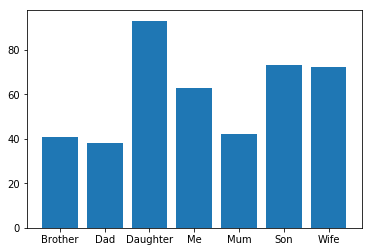

In [18]:
import matplotlib.pyplot as plt                        
%matplotlib inline
plt.bar(stats_dict.keys(), stats_dict.values())

### Loading the Images and Split Them into Train, Validation and Test Datasets

In [19]:
# Function to load the images as a list of file names and one hot code categories
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from glob import glob

# Read all the files and return 2 numpy arrays.
# One is the address of the files and the other one is the one hot encode of the category.
def load_dataset(folder_addr):
    """Load all the files in the given directory. The name of each subdirectory will be the category name.
    Args:
        folder_addr (str): The folder address in which there are subfolders.
    Returns:
        face_files (list[str]): A list of face file address strings.
        face_targets (numpy.ndarray): Numpy array of categories, value from 0 to 6, without one-hot encoding.
    """
    data = load_files(folder_addr)
    face_files = np.array(data['filenames'])
#     face_targets = np_utils.to_categorical(np.array(data['target']), 7)
    face_targets = data['target']
    return face_files, face_targets

Using TensorFlow backend.


In [20]:
# Load the list of images and categories
faces, targets = load_dataset('./images')
face_names = [item[9:-1] for item in glob('./images/*/')]
print('There are %d face categories.' % len(face_names))
print(face_names)
print('There are %d total faces.' % len(faces))
print(count_each_category(categories, faces))

There are 7 face categories.
['Brother', 'Dad', 'Daughter', 'Me', 'Mum', 'Son', 'Wife']
There are 422 total faces.
{'Daughter': 93, 'Brother': 41, 'Wife': 72, 'Son': 73, 'Mum': 42, 'Dad': 38, 'Me': 63}


A random check on the file name and category name.

In [21]:
def parse_image_category(file_addr, category_code, is_one_hot=False):
    """Given the category one hot code, return the index and name of the category of an image.
    Args:
        file_addr (str): The address of the image whose name contains the category name.
        category_code (int or numpy.nparray): Integer index of the category or numpy array after one-hot encoding.
        is_one_hot (bool): Default it's False, set to True if the passed in category_code is in one-hot format.
    Returns:
        category_index (int): The index of the category, from 0 to 6.
        face_names[category_index] (str): The name of the category.
    """
    # Print file path and category in one hot code
    print(file_addr, category_code)
    if is_one_hot:
        category_index = np.argmax(category_code)
    else:
        category_index = category_code
    return category_index, face_names[category_index]

parse_image_category(faces[100], targets[100])

./images\Me\20101120-2224-10.jpg-face-1.jpg 3


(3, 'Me')

From this point, the data set is finally ready for the coming machine learning piplines.

## III. Methodology and Implementation
### Algorithms and Techniques

The input image is with size of 299 \* 299 pixels, 3 channels for a color pixel, that's a space with almost 270k dimensions. It's too big to be processed directly by the machine learning algorithms. Hence, Google Inception V3 will be applied first to extract the feature vectors with dimensionality of 2048. Maybe it's still too big in this project but we'll see.

A linear classifier will be applied first. Its performance will be used as the baseline of the benchmark model. Subsequently, KNN, KNN+PCA and Deep Learning models will be applied and measured against the linear classifier.

As shown in the earlier section, around 500 images were chosen and number of samples for each category is not so balanced. Despite Google Inception V3 helped eliminate the necessity of having many samples for image recognition, it's still possible that my dataset is too small. So if it's needed, techniques like using [image generator](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) will be explored in this project.

### Extract Feature Vectors

In [22]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image

In [23]:
def path_to_tensor(img_path):
    """Given one image path, return it as a numpy array.
    Args:
        img_path (str): The full path string of a image.
    Returns:
        np.expand_dims(x, axis=0): A 4D numpy array of a image after expanding from 3D to 4D.
    """
    img = image.load_img(img_path, target_size=(299,299))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    """Given the image paths, return them as a vertically stacked numpy array.
    Args:
        img_paths (list[str]): The full paths of the images in a list.
    Returns:
        np.vstack(list_of_tensors) (numpy.ndarray): 4D numpy array of all the images.
    """
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

In [24]:
# Load the inception v3 model, include the dense layers
base_model = InceptionV3(weights='imagenet', include_top=True)
vector_out = base_model.get_layer('avg_pool')
feature_model = Model(inputs=base_model.input, outputs=vector_out.output)
feature_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, None, None, 32 96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, None, None, 32 0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [25]:
def get_features(feature_model, tensors):
    """Using the given model to convert a tensor/image to a feature vector
    Args:
        feature_model (Keras Model): In this project, it's the Google Inception V3 model without the last dense layer.
        tensors (numpy.ndarray): Group of images in a 4D numpy array.
    Returns:
        feature_outputs (numpy.ndarray): Feature vectors of the group of images, dimension of (x, 2018)
    """
    tensor_inputs = np.expand_dims(tensors, axis=0)
    feature_outputs = feature_model.predict(tensors)
    return feature_outputs

Split the dataset into train, validate and test datasets. The data are not well balanced based on the earlier bar plot diagram. Hence, straitified split function will be used here.

In [34]:
train_faces, test_faces, train_targets, test_targets = train_test_split(faces, targets, test_size=0.15, random_state=1, stratify=targets)
train_faces, validate_faces, train_targets, validate_targets = train_test_split(train_faces, train_targets, test_size=0.2, random_state=1, stratify=train_targets)
print('There are %d training faces.' % len(train_faces))
print(count_each_category(categories, train_faces))
print('There are %d validate faces.' % len(validate_faces))
print(count_each_category(categories, validate_faces))
print('There are %d test faces.' % len(test_faces))
print(count_each_category(categories, test_faces))

There are 286 training faces.
{'Daughter': 63, 'Brother': 28, 'Wife': 49, 'Son': 49, 'Mum': 29, 'Dad': 26, 'Me': 42}
There are 72 validate faces.
{'Daughter': 16, 'Brother': 7, 'Wife': 12, 'Son': 13, 'Mum': 7, 'Dad': 6, 'Me': 11}
There are 64 test faces.
{'Daughter': 14, 'Brother': 6, 'Wife': 11, 'Son': 11, 'Mum': 6, 'Dad': 6, 'Me': 10}


In [35]:
# Read the images as numpy arrays
train_tensors = paths_to_tensor(train_faces).astype('float32')/255
test_tensors = paths_to_tensor(test_faces).astype('float32')/255
validate_tensors = paths_to_tensor(validate_faces).astype('float32')/255
print("Train tensor shape.", train_tensors.shape)
print('Test tensor shape.', test_tensors.shape)
print('Validate tensor shape.', validate_tensors.shape)

Train tensor shape. (286, 299, 299, 3)
Test tensor shape. (64, 299, 299, 3)
Validate tensor shape. (72, 299, 299, 3)


In [36]:
train_features = get_features(feature_model, train_tensors)
validate_features = get_features(feature_model, validate_tensors)
test_features = get_features(feature_model, test_tensors)
print('Train features shape:', train_features.shape, '\nValidate feature_modelres shape: ', validate_features.shape,
      '\nTest features shape:', test_features.shape)

Train features shape: (286, 2048) 
Validate feature_modelres shape:  (72, 2048) 
Test features shape: (64, 2048)


### Training and Testing on Various Models
'Traditional' machine learning models of SGDClassifier, LogistricRegression, KNeighborsClassifier will be explored first. Then followed by deep neural network.

In [37]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
clf_A = SGDClassifier(max_iter=100, random_state=0)
clf_B = KNeighborsClassifier(n_neighbors=7)
clf_C = LogisticRegression(random_state=0)
%time model_A = clf_A.fit(train_features, train_targets)
%time model_B = clf_B.fit(train_features, train_targets)
%time model_C = clf_C.fit(train_features, train_targets)

Wall time: 336 ms
Wall time: 20 ms
Wall time: 477 ms


In [38]:
%time predict_test_A = model_A.predict(test_features)
%time predict_test_B = model_B.predict(test_features)
%time predict_test_C = model_C.predict(test_features)

Wall time: 1 ms
Wall time: 51 ms
Wall time: 1 ms


In [39]:
from sklearn.metrics import fbeta_score, accuracy_score

In [40]:
print(accuracy_score(test_targets, predict_test_A))
print(accuracy_score(test_targets, predict_test_B))
print(accuracy_score(test_targets, predict_test_C))

0.84375
0.703125
0.84375


In [50]:
test_targets, predict_test_A

(array([5, 1, 2, 2, 5, 1, 0, 2, 1, 1, 3, 4, 3, 0, 0, 6, 6, 5, 0, 1, 6, 2, 6,
        6, 3, 3, 3, 2, 6, 6, 2, 5, 6, 0, 5, 1, 3, 4, 6, 5, 4, 3, 6, 4, 2, 3,
        4, 2, 3, 5, 2, 5, 2, 2, 5, 2, 4, 2, 0, 3, 2, 5, 5, 6]),
 array([5, 1, 2, 2, 5, 1, 0, 2, 1, 1, 3, 4, 3, 0, 0, 3, 6, 5, 0, 1, 6, 2, 6,
        6, 3, 3, 1, 2, 6, 6, 2, 5, 6, 3, 5, 3, 3, 4, 6, 2, 4, 3, 2, 4, 2, 3,
        4, 5, 3, 5, 5, 5, 2, 2, 5, 2, 4, 2, 3, 3, 2, 2, 5, 6]))

So far all the chosen models performed training and prediction in fractions of a second. The accuracy is not so good, even though it's much better than random guess of 1/7 = 16.7%. Below is an exploration on using DNN model.

In [41]:
Inp = Input(shape=(2048,))
x = Dense(800, activation='relu')(Inp)
x = Dense(200, activation='relu')(x)
output = Dense(7, activation='softmax')(x)
my_model_1 = Model(inputs=Inp, outputs=output)
my_model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 800)               1639200   
_________________________________________________________________
dense_2 (Dense)              (None, 200)               160200    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 1407      
Total params: 1,800,807
Trainable params: 1,800,807
Non-trainable params: 0
_________________________________________________________________


In [42]:
train_targets_one_hot = np_utils.to_categorical(train_targets)
validate_targets_one_hot = np_utils.to_categorical(validate_targets)
test_targets_one_hot = np_utils.to_categorical(test_targets)

In [43]:
my_model_1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='my_model_1.h5', verbose=1, save_best_only=True)

In [51]:
%%time
hist_1 = my_model_1.fit(train_features, train_targets_one_hot,
            validation_data=(validate_features, validate_targets_one_hot),
            epochs=50, verbose=1, batch_size=20,
            callbacks=[checkpointer])

Train on 286 samples, validate on 72 samples
Epoch 1/50
286/286 [==============================] - 0s - loss: 0.0097 - acc: 1.0000 - val_loss: 0.8398 - val_acc: 0.7917
Epoch 2/50
286/286 [==============================] - 0s - loss: 0.1453 - acc: 0.9755 - val_loss: 0.9935 - val_acc: 0.7778
Epoch 3/50
286/286 [==============================] - 0s - loss: 0.4795 - acc: 0.8951 - val_loss: 0.9941 - val_acc: 0.7778
Epoch 4/50
286/286 [==============================] - 0s - loss: 0.0073 - acc: 1.0000 - val_loss: 0.8816 - val_acc: 0.8056
Epoch 5/50
286/286 [==============================] - 0s - loss: 0.1399 - acc: 0.9755 - val_loss: 0.8914 - val_acc: 0.7778
Epoch 6/50
286/286 [==============================] - 0s - loss: 0.0653 - acc: 0.9860 - val_loss: 1.5173 - val_acc: 0.6944
Epoch 7/50
286/286 [==============================] - 0s - loss: 0.0095 - acc: 0.9965 - val_loss: 1.0442 - val_acc: 0.7917
Epoch 8/50
286/286 [==============================] - 0s - loss: 0.0017 - acc: 1.0000 - val_lo

In [52]:
## TODO: Visualize the training and validation loss of your neural network
import matplotlib.pyplot as plt
def plt_hist(hist):
    print(hist.history.keys())
    # summarize history for accuracy
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


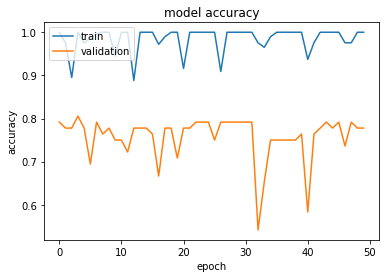

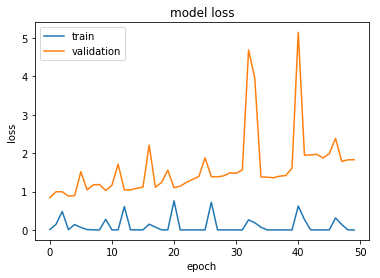

In [53]:
plt_hist(hist_1)

In [54]:
my_model_1 = load_model('./my_model_1.h5')
%time score = my_model_1.evaluate(test_features, test_targets_one_hot, verbose=0)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

Wall time: 186 ms

Test loss: 0.405936330557
Test accuracy: 0.859375


Based on the current split of the dataset, it's difficult to tell which model performs the best. SGDClassifier, KNN and DNN all reached test accuracy of 85%. DNN took significant longer time on training, as well as prediction.

## IV. Refinement

### With Straitified K-fold CV, no image geneartor

In [69]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(faces, targets)

10

In [72]:
for train_index, test_index in skf.split(faces, targets):
    x_train, x_test = faces[train_index], faces[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    print('Train:', count_each_category(categories, x_train))
    print('Test:', count_each_category(categories, x_test))
    print(test_index)

Train: {'Daughter': 83, 'Brother': 36, 'Wife': 64, 'Son': 65, 'Mum': 37, 'Dad': 34, 'Me': 56}
Test: {'Daughter': 10, 'Brother': 5, 'Wife': 8, 'Son': 8, 'Mum': 5, 'Dad': 4, 'Me': 7}
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29 30 31 32 33 34 35 36 37 38 40 42 43 46 51 52 53 55 63]
Train: {'Daughter': 83, 'Brother': 37, 'Wife': 64, 'Son': 65, 'Mum': 37, 'Dad': 34, 'Me': 56}
Test: {'Daughter': 10, 'Brother': 4, 'Wife': 8, 'Son': 8, 'Mum': 5, 'Dad': 4, 'Me': 7}
[ 25  39  41  44  45  47  48  49  50  54  56  57  58  59  60  61  62  64
  65  66  67  68  69  70  71  72  73  75  78  79  80  81  82  83  84  86
  87  93  96  98 101 102 107 110 111 112]
Train: {'Daughter': 83, 'Brother': 37, 'Wife': 65, 'Son': 65, 'Mum': 38, 'Dad': 34, 'Me': 56}
Test: {'Daughter': 10, 'Brother': 4, 'Wife': 7, 'Son': 8, 'Mum': 4, 'Dad': 4, 'Me': 7}
[ 74  76  77  85  88  89  90  91  92  94  95  99 100 103 106 108 109 113
 114 115 116 117 120 121 122 123 124 125 126 127 128

In [204]:
my_model_1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='my_model_1.h5',
                              verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10, cooldown=0, min_lr=0.00001)
lr_print = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('lr:', K.eval(my_model_1.optimizer.lr)))

## Part 3 - Improve accuracy with more images
More images were added to existing folder, just need to refresh the tensors and models.

./images/Train\Mum\20160805-2119.jpg-face-0.jpg [ 0.  0.  0.  0.  1.  0.  0.]
4
Mum


In [44]:
# Read the images as numpy arrays, normalize
train_tensors = paths_to_tensor(train_faces).astype('float32')/255
test_tensors = paths_to_tensor(test_faces).astype('float32')/255
validate_tensors = paths_to_tensor(validate_faces).astype('float32')/255
print('Train tensor shape.', train_tensors.shape)
print('Test tensor shape.', test_tensors.shape)
print('Validate tensor shape.', validate_tensors.shape)

Train tensor shape. (257, 299, 299, 3)
Test tensor shape. (98, 299, 299, 3)
Validate tensor shape. (73, 299, 299, 3)


In [ ]:
# It's exactly the same structure as my_model_1
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1000, activation = 'relu')(x)
x = Dense(200, activation = 'relu')(x)
x = Dense(50, activation = 'relu')(x)
x = Dense(7, activation = 'softmax')(x)

my_model_2 = Model(inputs = base_model.input, outputs = x)
my_model_2.summary()

In [48]:
my_model_2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='my_model_2.h5',
                              verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, cooldown=0, min_lr=0.00001)
lr_print = LambdaCallback(on_epoch_begin=lambda epoch, logs: print('lr:', K.eval(my_model_2.optimizer.lr)))

In [49]:
hist_2 = my_model_2.fit(train_tensors, train_targets,
            validation_data=(validate_tensors, validate_targets),
            epochs=200, verbose=1, batch_size=20,
            callbacks=[checkpointer, early_stopping, reduce_lr, lr_print])

Train on 257 samples, validate on 73 samples
lr: 0.001
Epoch 1/200
257/257 [==============================] - 5s - loss: 2.9185 - acc: 0.1323 - val_loss: 1.9750 - val_acc: 0.2740
lr: 0.001
Epoch 2/200
257/257 [==============================] - 4s - loss: 1.9081 - acc: 0.2879 - val_loss: 1.7492 - val_acc: 0.4110
lr: 0.001
Epoch 3/200
257/257 [==============================] - 2s - loss: 1.6857 - acc: 0.3346 - val_loss: 2.0031 - val_acc: 0.1918
lr: 0.001
Epoch 4/200
257/257 [==============================] - 2s - loss: 1.6810 - acc: 0.3424 - val_loss: 1.8424 - val_acc: 0.3151
lr: 0.001
Epoch 5/200
257/257 [==============================] - 4s - loss: 1.5162 - acc: 0.4047 - val_loss: 1.7223 - val_acc: 0.2329
lr: 0.001
Epoch 6/200
257/257 [==============================] - 5s - loss: 1.2774 - acc: 0.4981 - val_loss: 1.3982 - val_acc: 0.3562
lr: 0.001
Epoch 7/200
257/257 [==============================] - 2s - loss: 1.1237 - acc: 0.5370 - val_loss: 1.7943 - val_acc: 0.3151
lr: 0.001
Epoch 8

257/257 [==============================] - 2s - loss: 0.0123 - acc: 0.9961 - val_loss: 0.7234 - val_acc: 0.8904
lr: 0.000729
Epoch 64/200
257/257 [==============================] - 2s - loss: 0.0126 - acc: 0.9961 - val_loss: 2.7844 - val_acc: 0.5753
lr: 0.000729
Epoch 65/200
257/257 [==============================] - 2s - loss: 0.2814 - acc: 0.9339 - val_loss: 0.7638 - val_acc: 0.8904
Epoch 00064: early stopping


dict_keys(['loss', 'val_loss', 'val_acc', 'acc', 'lr'])


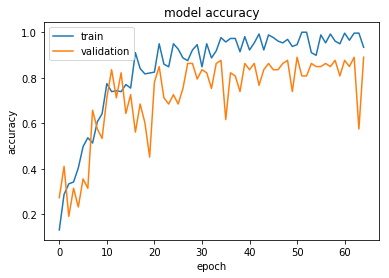

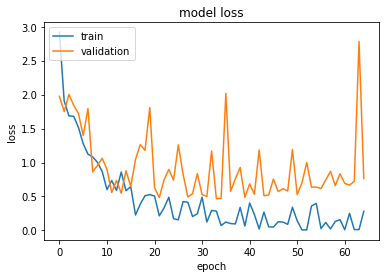

In [50]:
plt_hist(hist_2)

In [52]:
my_model_2 = load_model('./my_model_2.h5')

In [53]:
score_2 = my_model_2.evaluate(test_tensors, test_targets, verbose=1)
print('Test loss:', score_2[0])
print('Test accuracy:', score_2[1])

96/98 [============================>.] - ETA: 0sTest loss: 0.32326669839
Test accuracy: 0.887755102041


In [54]:
score_1 = my_model_1.evaluate(test_tensors, test_targets, verbose=1)
print('Test loss:', score_1[0])
print('Test accuracy:', score_1[1])

96/98 [============================>.] - ETA: 0sTest loss: 0.547816322774
Test accuracy: 0.816326530612


More data actually helps improve the accuracy. The second model shows 7% higher accuracy against the same set of testing data.

## Part 4 - Face recognition on sample photos
There are two family photos 'test_1.jpg' and 'test_2.jpg' in the root of working directory. Both of them were not used for training or testing in the earlier sections. Let's first perform a face detection using the `process_faces()`.

Image path ./test_1.jpg
(4912, 7360, 3)
Number of faces detected: 7


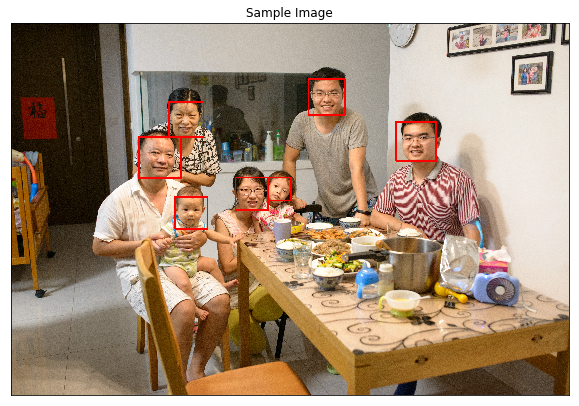

In [76]:
process_faces('./test_1.jpg', DISPLAY, NOSAVE, 1.3, 7)

Image path ./test_2.jpg
(4766, 7141, 3)
Number of faces detected: 4


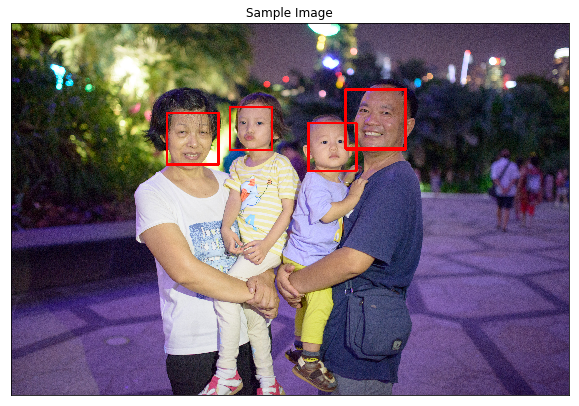

In [77]:
process_faces('./test_2.jpg', DISPLAY, NOSAVE, 1.35, 5)

Use one photo from the testing dataset to predict and return the result as index of the `face_names`.

In [147]:
one_test = test_tensors[56].reshape(-1, 299, 299, 3)
predict_idx = np.argmax(my_model_2.predict(one_test))
print(test_faces[56])
print(face_names)
print('The predicted face is: ', face_names[predict_idx])

./images/Test\Dad\20110204-1825.jpg-face-0.jpg
['Brother', 'Dad', 'Daughter', 'Me', 'Mum', 'Son', 'Wife']
The predicted face is:  Dad


Now let's make customized `detect_faces()` and `recognize_faces()`

In [158]:
def recognize_face(image_face):
    # Conver the 3 channel RGB to 4-d tensor and normalize it
    image_face = image_face.reshape(-1, 299, 299, 3)/255
    predict_idx = np.argmax(my_model_2.predict(image_face))
    return face_names[predict_idx]

In [213]:
def detect_faces(file_path, display=False, recognize=False, scaleFactor=1.3, minNeighb=5):
    print('Image path', file_path)
    
    # The file path contains unicode characters, cannot use cv2.imread() directly
    file_stream = open(file_path, 'rb')
    bytes_arr = bytearray(file_stream.read())
    numpy_ar = np.asarray(bytes_arr, dtype=np.uint8)
    image = cv2.imdecode(numpy_ar, cv2.IMREAD_UNCHANGED)
    print(image.shape)
    
    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Convert the RGB  image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Extract the pre-trained face detector from an xml file
    face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

    # Detect the faces in image
    faces = face_cascade.detectMultiScale(gray, scaleFactor, minNeighb)

    # Print the number of faces detected in the image
    print('Number of faces detected:', len(faces))

    # Make a copy of the orginal image to draw face detections on
    image_with_detections = np.copy(image)

    # The list of detected faces
    image_faces = []
    # Get the bounding box for each detected face
    for (x,y,w,h) in faces:
        # Add a red bounding box to the detections image
        if w > 200:
            line_width = w//20
        else:
            line_width = 3
        cur_face = image[y:(y+h), x:(x+w)]
        image_faces.append(cur_face)
        
        # Draw the red rectangele on the image
        cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), line_width)
        if recognize:
            cur_face = cv2.resize(cur_face, (299,299))
            name = recognize_face(cur_face)
            
            print('x,y,w,h', x,y,w,h)
            print(name)
            
            # Write the returned name on the image
            cv2.putText(image_with_detections, name,
                        (x,y-100),cv2.FONT_HERSHEY_SIMPLEX, 7, (255,0,0),20,cv2.LINE_AA)

    if display:
        # Display the image with the detections
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
        ax.set_title('Test Image')
        ax.imshow(image_with_detections)
    os.chdir(cur_dir)

Image path ./test_2.jpg
(4766, 7141, 3)
Number of faces detected: 4
x,y,w,h 1997 1163 658 658
Mum
x,y,w,h 2798 1090 546 546
Daughter
x,y,w,h 3805 1292 614 614
Son
x,y,w,h 4285 857 765 765
Dad


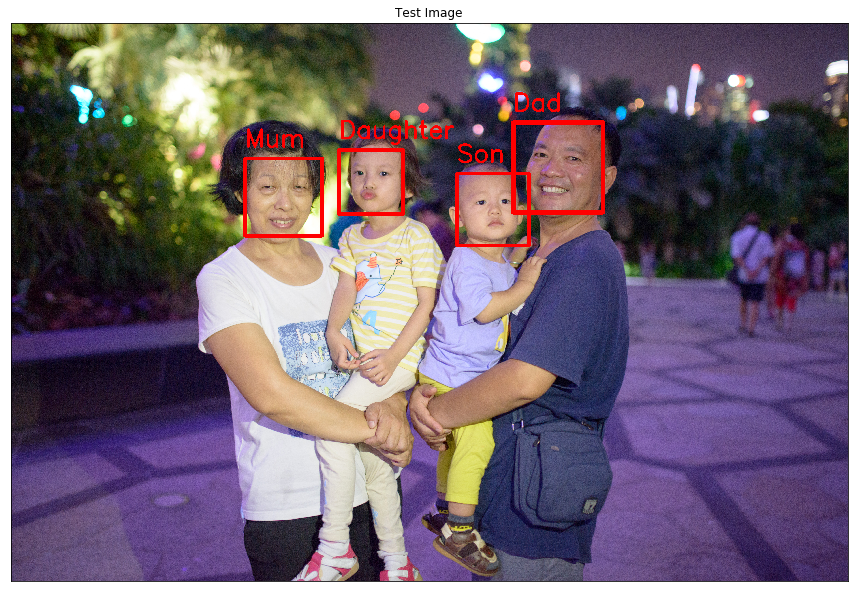

In [214]:
detect_faces('./test_2.jpg', True, True, 1.35, 5)

Image path ./test_1.jpg
(4912, 7360, 3)
Number of faces detected: 7
x,y,w,h 2080 1051 459 459
Mum
x,y,w,h 3923 750 477 477
Brother
x,y,w,h 2961 2047 430 430
Wife
x,y,w,h 1693 1509 550 550
Dad
x,y,w,h 2166 2300 427 427
Son
x,y,w,h 5083 1313 518 518
Brother
x,y,w,h 3392 2045 302 302
Daughter


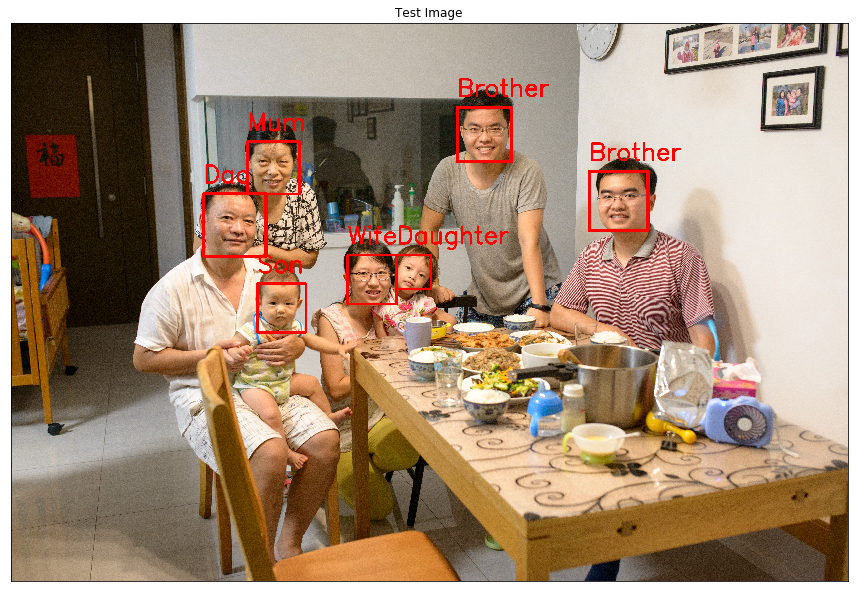

In [212]:
detect_faces('./test_1.jpg', True, True, 1.3, 7)

And now I finally have a 'theoretical' evidence that how much I look like my brother. Depite we're not twins, many friends say we look 'exactly' like twins!!!